# MY475 Seminar 2: pytorch

In this seminar, we are going to learn the basics of implementing multilayer perceptron models using **pytorch** -- one of the most popular libraries for deep learning. We will start by revisiting the basics of neural networks and then move on to implementing a simple model using **pytorch**.

We will build our basic implementation in three stages:

1. Defining the structure of a neural network
2. Handling data
3. Training a neural network

Our data this week comes from the [Cross-National Time Series Data Archive](https://www.cntsdata.com/). The dataset records various features of countries, over time, including a weighted measure of the extent of domestic conflict events (anti-government demonstrations, assissinations, guerilla warfare, purges, riots, revolutions, and general strikes). This variable is called `domestic9` and is going to be the target of our modelling exercise today.

## Defining the neural network structure

There are two crucial classes from torch that we need to use to define a (deep) neural network model:

a. `torch.nn.Module` -- this module contains all the background methods and attributes to define the model (including really annoying things like tracking parameters etc.)

    * In a typical model definition, we define the layers of the network as attributes and then define how data should flow through the network (the forward pass) by writing out a `forward` method.
  
b. `torch.nn.Linear` -- this module defines a linear set of connections (i.e., a fully connected layer) in the neural network. We use this to define each layer in the network.

    * The two main arguments for this class are the input and output sizes of the layer. You can think of a `torch.nn.Linear` layer as defining the connections between two layers of neurons in the network. So `torch.nn.layer(in_size, 32)` defines how the input layer of size `in_size` connects to the next layer of size 32

### Network construction exercises 

1. In the code chunk below, complete the definition of an `MLP` class that inherits from `torch.nn.Module`. In the constructor of this class, define **2** hidden layers, using an argument `hidden_nodes` to define the number of nodes in these layers. The input layer size should also be an argument of the constructor, called `input_size`. Finally, add a `hidden_act` attribute that is equal to `torch.nn.ReLU()` -- we will use this to activate the hidden layers.

2. Now complete the `forward()` method of `MLP`. The input data `x` should flow through each layer of the network in turn. Apply the hidden activation function attribute to the output of every hidden layer. Think carefully about how you activate the output layer.
   
   * Hint: it is commonplace to repeatedly overwrite x rather than defining separate variables for each step through the network.

3. Finally, instantiate a `model` of the `MLP` class and call it to see its structure

### A fully-connected neural network

In [25]:
import numpy as np
import torch

In [26]:
torch.manual_seed(89)
np.random.seed(89)

class MLP(torch.nn.Module):

    def __init__(self, input_size, hidden_nodes):
        super(MLP, self).__init__()  # Call the parent class constructor

        self.fc1 = torch.nn.Linear(input_size, hidden_nodes)
        self.fc2 = torch.nn.Linear(hidden_nodes, hidden_nodes)
        self.fc3 = torch.nn.Linear(hidden_nodes, 1)

        # activation function for hidden layers
        self.hidden_act = torch.nn.ReLU()

    def forward(self, x):

        x = self.hidden_act(self.fc1(x))
        x = self.hidden_act(self.fc2(x))
        x = self.fc3(x)
        return x

model = MLP(input_size=22, hidden_nodes=32)
print(model)

MLP(
  (fc1): Linear(in_features=22, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (hidden_act): ReLU()
)


## Handling data (as tensors) in torch

Last seminar, we defined a Value class. We couldn't just use numeric or integer types as we wanted to record more than just the data value itself, but also things like the gradient (and the various operations that are acceptable for Value objects).

The **pytorch** equivalent of this class is `torch.Tensor`. Most generally, tensors are abtract mathematical objects that store values in $k$ dimensions. Scalars are 0-dimensional tensors, vectors are 1-dimensional tensors, matrices are 2-dimensional tensors, and so on. To train neural networks, any input data must be converted to tensors before the network can process it.

* Working with data in torch is a little more involved than you might expect. If we read data in using `pandas` (for the convenient indexing etc.), we will need to convert any final DataFrame back to a numpy array (using the `.values` attribute). We can then convert this numpy array to a torch tensor using `torch.tensor()`. 
* When calling `torch.tensor()`, you can specify the data type of the tensor using the `dtype` argument. This is useful for ensuring that the data is in the correct format for the network.
* You need to make sure the shape of the tensor is what torch expects. Therefore, it is common to use the `.reshape` method to make the dimensions of the data correspond to the model architecture. This is often particularly relevant for the outcome variable, which should be a 2D tensor. For example, `data.reshape(-1,1)` will reshape the data to have 1 column and as many rows as necessary.

To help us format and cajole our data, we will also make use of two classes from the torch.utils.data library:

* `torch.utils.data.TensorDataset` -- this class is a simple wrapper for the more general `Dataset` class, which converts data to work within a torch modelling pipeline

    * This class takes in multiple tensor objects and combines them into a single dataset object. This is useful for when we have multiple input tensors (e.g., features and labels) that we want to keep together.

* `torch.utils.data.DataLoader` -- this class is used to load data from a `Dataset` object. It is an iterator that allows us to iterate over the data in batches, allowing us to perform mini-batch gradient descent (and control the batch size itself!)

### Data handling exercises

1. Complete the data handling code below:

    * Read in the seminar 2 data
    * Normalize *all* columns of the data to have a mean of 0 and a standard deviation of 1
    * Separate out observations recorded from 2020 into a test set, and create the corresponding `TensorDataset` object
    * Sample 20% of the remaining data for a validation set
    * Create `TensorDataset`s for the training and validation splits

2. Define three dataloaders for the training, validation, and test sets. Use a batch size of 64 for each dataloader.

In [27]:
import pandas as pd
from torch.utils.data import  DataLoader, TensorDataset

# Load the data
conflict_data = pd.read_csv('sem2_data.csv')

# Normalize the data
conflict_norm = (conflict_data - conflict_data.mean())/conflict_data.std()

# Create the test data for all observations after 2019

data_test = TensorDataset(
    torch.tensor(conflict_norm[conflict_data['year'] > 2019].drop(columns=['domestic9']).values, dtype=torch.float32),
    torch.tensor(conflict_norm[conflict_data['year'] > 2019]['domestic9'].values, dtype=torch.float32)
)

# Create the training data split, then separate out 20% for validation
conflict_train = conflict_norm[conflict_data['year'] <= 2019].copy()
conflict_val = conflict_train.sample(frac=0.2, random_state=89)
conflict_train.drop(conflict_val.index, inplace=True)

data_train = TensorDataset(
    torch.tensor(conflict_train.drop(columns=['domestic9']).values, dtype=torch.float32),
    torch.tensor(conflict_train['domestic9'].values, dtype=torch.float32)
)

data_val = TensorDataset(
    torch.tensor(conflict_val.drop(columns=['domestic9']).values, dtype=torch.float32),
    torch.tensor(conflict_val['domestic9'].values, dtype=torch.float32)
)


In [28]:
### Dataloaders
# For training we set shuffle=True to randomize batches.
train_dataloader = DataLoader(data_train, batch_size= 64, shuffle=True)
val_dataloader = DataLoader(data_val, batch_size = 64, shuffle=False)
test_dataloader = DataLoader(data_test, batch_size= 64, shuffle=False)

print(train_dataloader.dataset.tensors[0].shape)
print(val_dataloader.dataset.tensors[0].shape)
print(test_dataloader.dataset.tensors[0].shape)

torch.Size([9066, 22])
torch.Size([2267, 22])
torch.Size([792, 22])


## Optimisation

Our model is instantiated, but it's parameter values have been initialised to near zero. Now, we need to train it so that these values are optimised to make good predictions. 

In torch, you have to write your own optimisation routine (i.e. it's not an inbuilt method of a neural network object). Typically, this step will involve:

* Defining a loss `criterion` (e.g. mean squared error)
* Defining an optimiser (e.g. stochastic gradient descent) and any corresponding hyperparameters (e.g. the learning rate)
* Writing a training loop iterating over the dataloader, calculating and backpropagating the loss to update the parameters

### Optimisation exercises

1. Using the `torch.nn` library, define a loss function that calculates the mean squared error between the predicted and actual values
2. Using the `torch.optim` library, define an optimiser that uses *Adam* to update the parameters of the model. Set the learning rate equal to 0.001.
3. Define a `num_epochs` variable and set it equal to 500. Also create two lists (`tr_loss` and `val_loss`) to store the training and validation losses for each epoch.
4. Write a training loop that iterates over the training data `num_epochs` times. For each epoch:

    * Set the model to training mode
    * Iterate over the training dataloader, each time resetting the optimizer, making predictions on the batch, calculating the loss, backpropagating the loss, then updating the parameters. You should also *add* the loss for the batch to the `tr_loss` at the epoch's position.
    * Set the model to evaluation mode 
    * Within a `torch.no_grad()` block, iterate over the validation dataloader, making predictions on the batch and adding the los to the epoch's `val_loss` index. Then calculate the avergae batch loss for both the training and validation sets.
    * To track progress, every 10th epoch we will print out the current loss values. (This code has been provided for you)
    * As a basic way of choosing an early stopping point using our validation data, each time our validation loss is lower than the current minimum we will save the model's parameters using `torch.save()`. It is conventional to use the `.pt` file extension for this purpose.
    
Note: You may want to think why this "global" search (in the sense we consider all 500 epochs) for the minimum validation loss is probably not a good idea. What could be a better way to do this?

In [30]:
# Redefine our model, so we don't "warm start" a previously trained version
model = MLP(input_size = 22, hidden_nodes = 64)

# Initialize the model, loss function, and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 200
tr_loss = [0 for _ in range(num_epochs)]
val_loss = [0 for _ in range(num_epochs)]

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0

    # Training loop (mini-batch gradient descent)
    for X_batch, y_batch in train_dataloader:
        optimizer.zero_grad()  # always, ALWAYS zero your gradients
        y_pred = model(X_batch)  # automatically calls model.forward()
        loss = criterion(y_pred.squeeze(1), y_batch)  # loss functions expect 1D tensors
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    # Average training loss for this epoch
    tr_loss[epoch] = epoch_train_loss / len(train_dataloader)

     # Validation loop
    model.eval()  # set model to evaluation mode
    epoch_val_loss = 0.0
    with torch.no_grad():
        for X_val, y_val in val_dataloader:
            y_val_pred = model(X_val)
            loss_val = criterion(y_val_pred.squeeze(1), y_val)
            epoch_val_loss += loss_val.item()
    val_loss[epoch] = epoch_val_loss / len(val_dataloader)

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {tr_loss[epoch]:.4f}, Val. Loss: {val_loss[epoch]:.4f}')

    if epoch > 0 and val_loss[epoch] < min(val_loss[:epoch]):
        torch.save(model, 'conflict_best.pt')


Epoch [10/200], Loss: 0.0073, Val. Loss: 0.0089
Epoch [20/200], Loss: 0.0081, Val. Loss: 0.0066
Epoch [30/200], Loss: 0.0055, Val. Loss: 0.0064
Epoch [40/200], Loss: 0.0080, Val. Loss: 0.0056
Epoch [50/200], Loss: 0.0050, Val. Loss: 0.0069
Epoch [60/200], Loss: 0.0054, Val. Loss: 0.0086
Epoch [70/200], Loss: 0.0046, Val. Loss: 0.0053
Epoch [80/200], Loss: 0.0047, Val. Loss: 0.0065
Epoch [90/200], Loss: 0.0048, Val. Loss: 0.0059
Epoch [100/200], Loss: 0.0043, Val. Loss: 0.0052
Epoch [110/200], Loss: 0.0037, Val. Loss: 0.0081
Epoch [120/200], Loss: 0.0040, Val. Loss: 0.0047
Epoch [130/200], Loss: 0.0041, Val. Loss: 0.0063
Epoch [140/200], Loss: 0.0033, Val. Loss: 0.0047
Epoch [150/200], Loss: 0.0032, Val. Loss: 0.0042
Epoch [160/200], Loss: 0.0030, Val. Loss: 0.0086
Epoch [170/200], Loss: 0.0027, Val. Loss: 0.0095
Epoch [180/200], Loss: 0.0037, Val. Loss: 0.0054
Epoch [190/200], Loss: 0.0025, Val. Loss: 0.0057
Epoch [200/200], Loss: 0.0023, Val. Loss: 0.0044


To visualise the training process, we can plot the training and validation loss over epochs. I have provided you the matplotlib code to do this. Just run the code chunk below to see the plot!

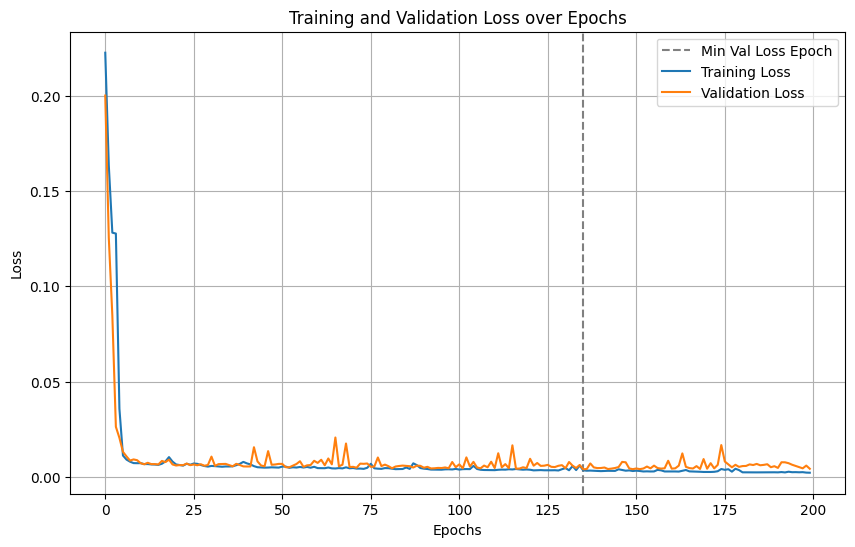

In [31]:
import matplotlib.pyplot as plt

min_tr_loss_index = np.argmin(val_loss)
min_tr_loss_index

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.axvline(x=min_tr_loss_index, color='grey', linestyle='--', label='Min Val Loss Epoch')
plt.plot(range(num_epochs), tr_loss, label='Training Loss')
plt.plot(range(num_epochs), val_loss, label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)

plt.savefig('conflict_training.png', dpi=300)
plt.show()


## Test time

Having trained our model, it is time to make one final evaluation on the test set.

### Test set exercises

1. Complete the below code to load the checkpoint with the lowest validation loss, and evaluate this model on the test set. Print out validation loss and the test loss.
2. What do you notice about the difference between the validation and test loss? Why do you think this is?

In [34]:
# Load the trained model
model = torch.load('conflict_best.pt')
model.eval()  # Set the model to evaluation mode

# Initialize test loss
test_loss = 0

# Ensure criterion is defined
criterion = torch.nn.MSELoss()  # Change this to the appropriate loss function used in training

# Ensure test_dataloader is defined
with torch.no_grad():
    for X_batch, y_batch in test_dataloader:
        y_pred = model(X_batch)
        test_loss += criterion(y_pred.squeeze(1), y_batch).item()

test_loss /= len(test_dataloader)

print(f"Min. validation loss: {min(val_loss):.4f}; Min. test loss: {test_loss:.4f}")


Min. validation loss: 0.0041; Min. test loss: 0.0313


## Other nasties

Sometimes our model won't train well with only feedforward layers. To improve the quality of our model, we can use some additional techniques:

* Dropout -- these layers randomly set a fraction of the input units to 0 at each update during training time
* Batch normalisation -- these layers normalise features within each batch
* Layer Normalisation -- these layer normalise outputs across the *layer*

Each technique can be defined as layers in our model definition:

* `torch.nn.Dropout(p=0.5)` -- this layer will randomly set 50% of the input units to 0
* `torch.nn.BatchNorm1d(num_features)` -- this layer will normalise the features of each batch, where `num_features` is the number of features in the input
* `torch.nn.LayerNorm(normalized_shape)` -- this layer will normalise the outputs of each layer, where `normalized_shape` is the shape of the output

### Tuning exercises

1. Try adding a dropout layer to the model definition, rerun training and see if the model trains better/worse
2. Remove dropout layers, and add batch normalisation *or* layer normalisation, but not both. 
3. Try adding both dropout and some form of hidden layer normalisation. Do you see any improvement?

Choose your best model and see if you can beat the performance of the more basic feedforward model!

In [ ]:
___

''